# Assignment: Runge Function Interpolation Errors

Problem: For the Runge function f(x) = 1/(1 + 25 x^2) on [-1, 1], find the smallest N such that the maximum approximation error over [-1,1] is < 1e-10, estimated using a fine grid of 20,001 points.

We will compute two cases:

1. Cubic spline interpolation on equidistant nodes using SciPy's interp1d(kind='cubic') (not-a-knot boundary conditions).
2. Polynomial interpolation at Chebyshev nodes of the second kind x_k = cos(pi * k / N), k = 0..N, using a barycentric interpolator.

The notebook performs a binary search over N for each method and reports the smallest N meeting the tolerance.

In [19]:
import numpy as np
import math
from scipy.interpolate import interp1d, BarycentricInterpolator
import time

# Runge function
def runge(x):
    return 1 / (1.0 + 25.0 * x**2)

# Fine grid for error estimation
x_fine = np.linspace(-1, 1, 20001)
y_true = runge(x_fine)

def chebyshev_second_kind_nodes(N, a=-1, b=1):
    k = np.arange(0, N+1)
    nodes = np.cos(np.pi * k / N)
    # map from [-1,1] to [a,b]
    return 0.5*(b-a)*nodes + 0.5*(a+b)


In [20]:
def max_error_cubic_spline(N):
    # Equally spaced nodes
    x_nodes = np.linspace(-1, 1, N+1)
    y_nodes = runge(x_nodes)
    # cubic spline (interp1d kind='cubic' uses not-a-knot)
    interp = interp1d(x_nodes, y_nodes, kind='cubic', assume_sorted=False)
    y_interp = interp(x_fine)
    return np.max(np.abs(y_interp - y_true))


def max_error_chebyshev(N):
    # Chebyshev nodes of the second kind (N is degree, includes endpoints k=0..N)
    x_nodes = chebyshev_second_kind_nodes(N, -1, 1)
    y_nodes = runge(x_nodes)
    interp = BarycentricInterpolator(x_nodes, y_nodes)
    y_interp = interp(x_fine)
    return np.max(np.abs(y_interp - y_true))

# New: cubic spline on Chebyshev nodes (second kind)
def max_error_chebyshev_cubic(N):
    # Generate Chebyshev nodes and sort them for interp1d
    x_nodes = chebyshev_second_kind_nodes(N, -1, 1)
    idx = np.argsort(x_nodes)
    x_nodes_sorted = x_nodes[idx]
    y_nodes_sorted = runge(x_nodes_sorted)
    interp = interp1d(x_nodes_sorted, y_nodes_sorted, kind='cubic', assume_sorted=True)
    y_interp = interp(x_fine)
    return np.max(np.abs(y_interp - y_true))

# Binary search utility to find minimal N s.t. error < tol
def find_min_N(func_error, tol, N_min=1, N_max=20000, verbose=False):
    lo = N_min
    hi = N_max
    best = None
    while lo <= hi:
        mid = (lo + hi) // 2
        err = func_error(mid)
        if verbose:
            print(f'N={mid}, err={err:.3e}')
        if err < tol:
            best = mid
            hi = mid - 1
        else:
            lo = mid + 1
    return best


In [21]:
tol = 1e-10
# Run binary search for cubic spline
start = time.time()
N_cubic = find_min_N(max_error_cubic_spline, tol, N_min=4, N_max=20000, verbose=False)
elapsed_cubic = time.time() - start

# Run binary search for Chebyshev interpolation
start = time.time()
N_cheb = find_min_N(max_error_chebyshev, tol, N_min=4, N_max=20000, verbose=False)
elapsed_cheb = time.time() - start    

# Find minimal N for Chebyshev + cubic spline
start = time.time()
N_cheb_cubic = find_min_N(max_error_chebyshev_cubic, tol, N_min=4, N_max=20000, verbose=False)
elapsed_cheb_cubic = time.time() - start

print(f'Minimal N (cubic spline): {N_cubic}, time: {elapsed_cubic:.2f}s')
print(f'Minimal N (Chebyshev): {N_cheb}, time: {elapsed_cheb:.2f}s')
print(f"Minimal N (Chebyshev + cubic spline): {N_cheb_cubic}, time: {elapsed_cheb_cubic:.2f}s")

# Show errors for the reported N
if N_cubic is not None:
    err_cubic = max_error_cubic_spline(N_cubic)
else:
    err_cubic = None
if N_cheb is not None:
    err_cheb = max_error_chebyshev(N_cheb)
else:
    err_cheb = None
if N_cheb_cubic is not None:
    err_cheb_cubic = max_error_chebyshev_cubic(N_cheb_cubic)
else:
    err_cheb_cubic = None

print(f'Error at N_cubic={N_cubic}: {err_cubic:.3e}')
print(f'Error at N_cheb={N_cheb}: {err_cheb:.3e}')

print(f'Error at N_cheb_cubic={N_cheb_cubic}: {err_cheb_cubic:.3e}')

Minimal N (cubic spline): 1582, time: 0.02s
Minimal N (Chebyshev): 118, time: 4.09s
Minimal N (Chebyshev + cubic spline): 2484, time: 0.02s
Error at N_cubic=1582: 9.967e-11
Error at N_cheb=118: 6.317e-11
Error at N_cheb_cubic=2484: 9.983e-11


# Plots: Interpolants and Error

Below we plot the Runge function, the cubic spline interpolant at the found N, and the Chebyshev interpolant at the found N. For each method we also show the pointwise absolute error on a semilog scale.

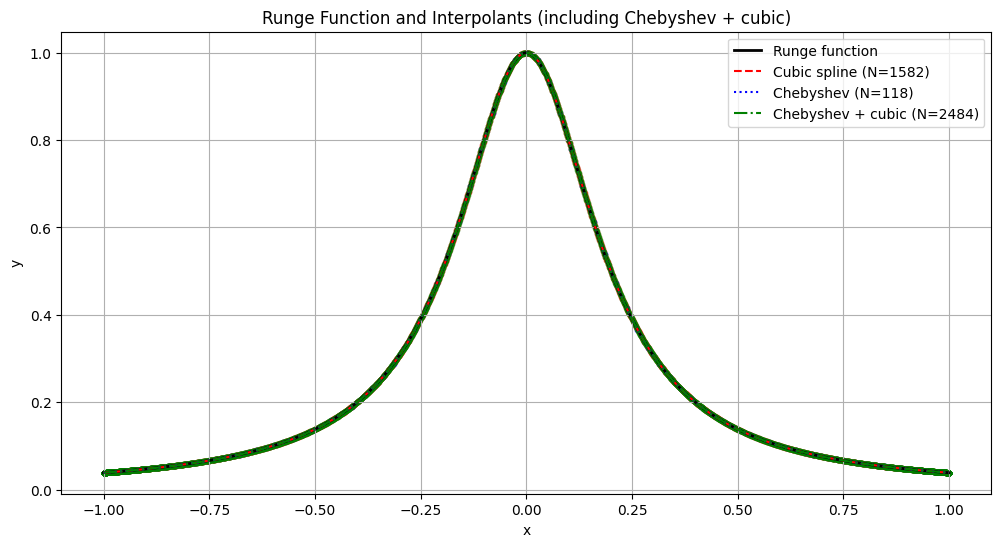

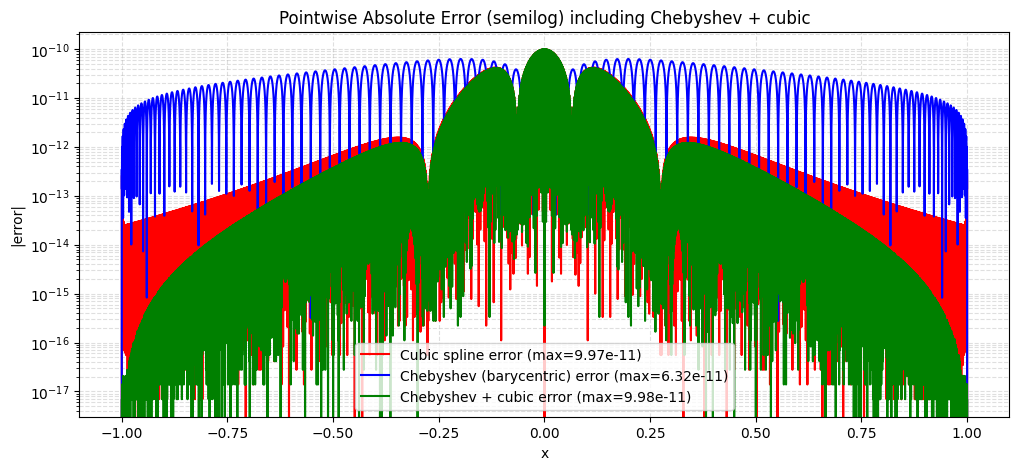

In [22]:
import matplotlib.pyplot as plt

# Build interpolants at found N values
# Cubic spline
x_nodes_cubic = np.linspace(-1, 1, N_cubic+1)
y_nodes_cubic = runge(x_nodes_cubic)
interp_cubic = interp1d(x_nodes_cubic, y_nodes_cubic, kind='cubic', assume_sorted=True)
y_cubic = interp_cubic(x_fine)
err_cubic_pointwise = np.abs(y_cubic - y_true)

# Chebyshev
x_nodes_cheb = chebyshev_second_kind_nodes(N_cheb, -1, 1)
y_nodes_cheb = runge(x_nodes_cheb)
interp_cheb = BarycentricInterpolator(x_nodes_cheb, y_nodes_cheb)
y_cheb = interp_cheb(x_fine)
err_cheb_pointwise = np.abs(y_cheb - y_true)

# Chebyshev + cubic spline
x_nodes_cheb_cubic = chebyshev_second_kind_nodes(N_cheb_cubic, -1, 1)
idx = np.argsort(x_nodes_cheb_cubic)
x_nodes_cheb_cubic = x_nodes_cheb_cubic[idx]
y_nodes_cheb_cubic = runge(x_nodes_cheb_cubic)
interp_cheb_cubic = interp1d(x_nodes_cheb_cubic, y_nodes_cheb_cubic, kind='cubic', assume_sorted=True)
y_cheb_cubic = interp_cheb_cubic(x_fine)
err_cheb_cubic_pointwise = np.abs(y_cheb_cubic - y_true)

# Plot function and interpolants
plt.figure(figsize=(12, 6))
plt.plot(x_fine, y_true, 'k-', label='Runge function', linewidth=2)
plt.plot(x_fine, y_cubic, 'r--', label=f'Cubic spline (N={N_cubic})')
plt.plot(x_fine, y_cheb, 'b:', label=f'Chebyshev (N={N_cheb})')
plt.plot(x_fine, y_cheb_cubic, 'g-.', label=f'Chebyshev + cubic (N={N_cheb_cubic})')
plt.scatter(x_nodes_cubic, y_nodes_cubic, c='r', s=10, alpha=0.6)
plt.scatter(x_nodes_cheb, y_nodes_cheb, c='b', s=10, alpha=0.6)
plt.scatter(x_nodes_cheb_cubic, y_nodes_cheb_cubic, c='g', s=10, alpha=0.6)
plt.legend()
plt.title('Runge Function and Interpolants (including Chebyshev + cubic)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Plot pointwise error on semilog scale
plt.figure(figsize=(12, 5))
plt.semilogy(x_fine, err_cubic_pointwise, 'r-', label=f'Cubic spline error (max={err_cubic:.2e})')
plt.semilogy(x_fine, err_cheb_pointwise, 'b-', label=f'Chebyshev (barycentric) error (max={err_cheb:.2e})')
plt.semilogy(x_fine, err_cheb_cubic_pointwise, 'g-', label=f'Chebyshev + cubic error (max={err_cheb_cubic:.2e})')
plt.legend()
plt.title('Pointwise Absolute Error (semilog) including Chebyshev + cubic')
plt.xlabel('x')
plt.ylabel('|error|')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.show()